In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pickle

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print
from core_lib import MyDataset, plot_dataset,r2_loss,get_predict_ks, get_dcdt_func_for_sunode
from core_lib import get_predict_starts
from core_lib import get_model, get_model2, distance_func, MY_EPSILON
# from core_lib import get_sunode_model_v2

print(pm.__version__)


'4.0.0'

/Users/izhangxm/WorkStation/VSCode/N15Tracing/core_lib/data.py:247: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


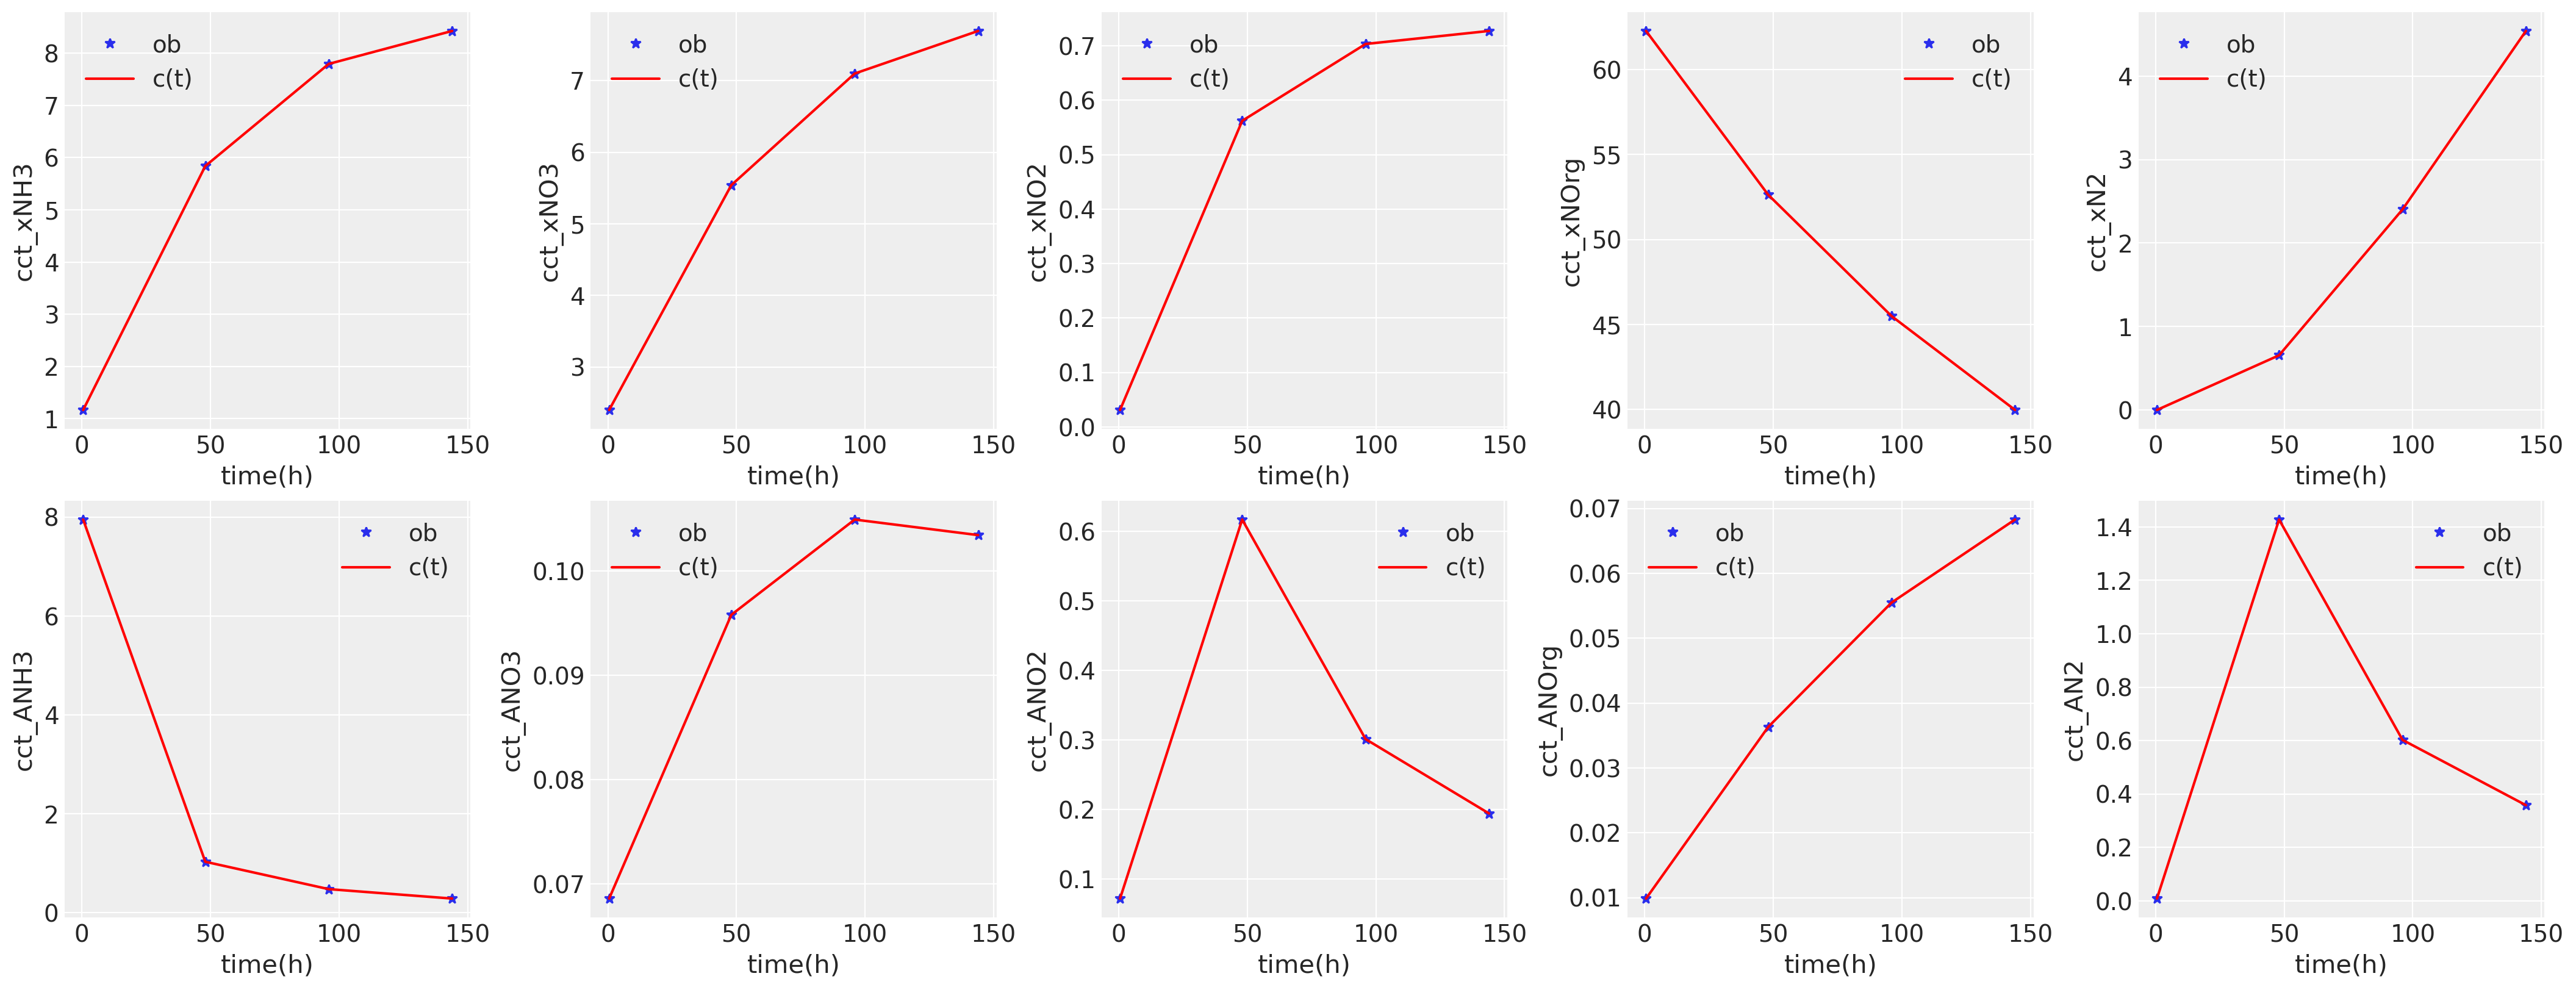

In [2]:
db_csv_path = "dataset/data.csv"
idata_save_path = "runtime/pts/odes-exp04-idata-4-number-1core-c0number-halfnormks-from-core.py-success.dt"

dataset_ori = MyDataset(db_csv_path)
df_ori = dataset_ori.get_df()
cct_names, error_names = dataset_ori.get_var_col_names()
c0 = df_ori[cct_names].iloc[0].values

# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8)
# k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8)
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================

# t_eval = np.linspace(0, 150, 100)
t_eval = np.array([0.5, 48, 96, 144])

dataset = MyDataset(db_csv_path)
df = dataset.get_df()
cct_names, error_names = dataset.get_var_col_names()
c0 = df[cct_names].iloc[0].values

dataset.set_as_sim_dataset(t_eval, c0, t0=0.5, args=(ks, k_kinetics))
df = dataset.get_df()

plot_dataset(dataset, dataset)


In [4]:


def get_dcdt_func_for_sunode_v2(k_kinetics):
    k_kinetics = np.array(k_kinetics).astype(np.uint8)
    def _dcdt_func(t, c, p):
        k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11 = p.ks
        xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2 = c.c0
        kt1,kt2,kt3,kt4,kt5,kt6,kt7,kt8,kt9,kt10,kt11 = k_kinetics
        
        r1 = k1 * xN2 if kt1 == 1 else k1
        r2 = k2 * xNH3 if kt2 == 1 else k2
        r3 = k3 * xNO2 if kt3 == 1 else k3
        r4 = k4 * xNO3 if kt4 == 1 else k4
        r5 = k5 * xNO2 if kt5 == 1 else k5
        r6 = k6 * xNO2 * xNO3 if kt6 == 1 else k6
        r7 = k7 * xNO3 if kt7 == 1 else k7
        r8 = k8 * xNO3 if kt8 == 1 else k8
        r9 = k9 * xNH3 if kt9 == 1 else k9
        r10 = k10 * xNOrg if kt10 == 1 else k10
        r11 = k11 * xNOrg if kt11 == 1 else k11
        
        dc_xNH3 = 2 * r1 + r7 + r10 - r2 - r6 - r9
        dc_xNO3 = r3 - r7 - r4 - r8 + r11
        dc_xNO2 = r2 + r4 - r3 - r6 - 2 * r5
        dc_xNOrg = r8 + r9 - r10 - r11
        dc_xN2 = r5 + r6 - r1

        dc_ANH3 = (2 * r1 * (AN2 - ANH3) + (ANO3 - ANH3) * r7 + (ANOrg - ANH3) * r10) / xNH3
        dc_ANO3 = ((ANO2 - ANO3) * r2 + (ANOrg - ANO3) * r11) / xNO3
        dc_ANO2 = ((ANH3 - ANO2) * r2 + (ANO3 - ANO2) * r4) / xNO2
        dc_ANOrg = ((ANO3 - ANOrg) * r8 + (ANH3 - ANOrg) * r9) / xNOrg
        dc_AN2 = ((ANO2 - AN2) * r5 + (ANO2 * ANH3 - AN2) * r6) / xN2

        dcdts0 = [dc_xNH3, dc_xNO3, dc_xNO2, dc_xNOrg, dc_xN2, dc_ANH3, dc_ANO3, dc_ANO2, dc_ANOrg, dc_AN2]
        return {"c0":dcdts0}
        
        dcdts =  {
            'xNH3': dc_xNH3,
            'xNO3': dc_xNO3,
            'xNO2': dc_xNO2,
            'xNOrg': dc_xNOrg,
            'xN2': dc_xN2,
            'ANH3': dc_ANH3,
            'ANO3': dc_ANO3,
            'ANO2': dc_ANO2,
            'ANOrg': dc_ANOrg,
            'AN2': dc_AN2,
        }
        return dcdts
    
    return _dcdt_func



def get_sunode_model_v2(dataset, t_eval, k_kinetics, k_sigma_priors=0.001, kf_type=0):
    import sunode
    import sunode.wrappers
    df = dataset.get_df()
    times = df['time'].values
    
    errors = dataset.get_errors()
    rates = dataset.get_rates()
    cct_names, error_names = dataset.get_var_col_names()
        
    # 定义参数优化模型
    mcmc_model = pm.Model()
    ## 参数个数
    params_n = 11
    parames ={}
    
    with mcmc_model:
        # for ki in range(1, params_n + 1):
        #     if kf_type == 0:
        #         p_dense = pm.HalfNormal(f"k{ki}", sigma=k_sigma_priors)
        #     else:
        #         p_dense = pm.Normal(f"k{ki}",mu=0, sigma=k_sigma_priors)
        #     parames[f"k{ki}"] = (p_dense, ())
        p_dense = pm.HalfNormal("ks",  sigma=k_sigma_priors, shape=11)
        parames[f"ks"] = (p_dense, (11,))
    
    # parames['extra']=  np.zeros(1)
    
    c0 = {}
    with mcmc_model:
        _mxx = []
        for c_name in cct_names:
            _maxx = df[c_name].values.max()
            # c0[f"{c_name}"] = (pm.HalfNormal(f"{c_name}_s", sigma=_maxx), ())
        
        c0 = pm.HalfNormal(f"c0",  sigma=2, shape=10)
        sunode_c0 = {"c0": (c0, (10,))}
        
        
        y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
            y0=sunode_c0,
            params=parames,
            rhs=get_dcdt_func_for_sunode_v2(k_kinetics),
            tvals=times,
            t0=times[0],
        )
        sd = pm.HalfNormal('sd')
        pm.Normal('cct_ob', mu=y_hat["c0"], sigma=sd ,observed=dataset.get_cct())
        # pm.Deterministic(f'cct_ob_mu', y_hat[f"c0"])
        
    return mcmc_model

mcmc_model = get_sunode_model_v2(dataset, t_eval, k_kinetics, k_sigma_priors=0.001, kf_type=0)
pm.model_to_graphviz(mcmc_model)



ValueError: When changing to a smaller dtype, its size must be a divisor of the size of original dtype
Apply node that caused the error: SolveODEAdjoint{_solver_id=11213386656}(c0, ks, TensorConstant{[]}, TensorConstant{0.5}, TensorConstant{[  0.5  48..6.  144. ]})
Toposort index: 2
Inputs types: [TensorType(float64, (None,)), TensorType(float64, (None,)), TensorType(float64, (0,)), TensorType(float64, ()), TensorType(float64, (4,))]
Inputs shapes: [(10,), (11,), (0,), (), (4,)]
Inputs strides: [(8,), (8,), (0,), (), (8,)]
Inputs values: ['not shown', 'not shown', array([], dtype=float64), array(0.5), array([  0.5,  48. ,  96. , 144. ])]
Outputs clients: [[Shape_i{1}(SolveODEAdjoint{_solver_id=11213386656}.0), Shape_i{0}(SolveODEAdjoint{_solver_id=11213386656}.0)]]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_27935/376354787.py", line 105, in <module>
    mcmc_model = get_sunode_model_v2(dataset, t_eval, k_kinetics, k_sigma_priors=0.001, kf_type=0)
  File "/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_27935/376354787.py", line 92, in get_sunode_model_v2
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
  File "/Users/izhangxm/WorkStation/VSCode/sunode/sunode/wrappers/as_pytensor.py", line 132, in solve_ivp
    flat_solution = wrapper(y0_flat, params_subs_flat, params_remaining_flat, t0, tvals)

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [4]:
idata_lv = pm.sample(draws=2000, chains=2, model=mcmc_model, progressbar=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: When changing to a smaller dtype, its size must be a divisor of the size of original dtype
Apply node that caused the error: SolveODEAdjoint{_solver_id=5450561328}(c0_log___log, ks_log___log, TensorConstant{[]}, TensorConstant{0.5}, TensorConstant{[  0.5  48..6.  144. ]})
Toposort index: 8
Inputs types: [TensorType(float64, (10,)), TensorType(float64, (11,)), TensorType(float64, (0,)), TensorType(float64, ()), TensorType(float64, (4,))]
Inputs shapes: [(10,), (11,), (0,), (), (4,)]
Inputs strides: [(8,), (8,), (0,), (), (8,)]
Inputs values: ['not shown', 'not shown', array([], dtype=float64), array(0.5), array([  0.5,  48. ,  96. , 144. ])]
Outputs clients: [[Subtensor{::, int64:int64:}(SolveODEAdjoint{_solver_id=5450561328}.0, ScalarConstant{0}, ScalarConstant{10})]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymc5/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
    result = runner(coro)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymc5/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymc5/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymc5/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/pymc5/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_27787/376354787.py", line 105, in <module>
    mcmc_model = get_sunode_model_v2(dataset, t_eval, k_kinetics, k_sigma_priors=0.001, kf_type=0)
  File "/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_27787/376354787.py", line 92, in get_sunode_model_v2
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
  File "/Users/izhangxm/WorkStation/VSCode/sunode/sunode/wrappers/as_pytensor.py", line 132, in solve_ivp
    flat_solution = wrapper(y0_flat, params_subs_flat, params_remaining_flat, t0, tvals)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.